In [19]:
# Required Libraries 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from collections import Counter
import warnings 
warnings.filterwarnings('ignore')


In [9]:
#Load Dataset
df = pd.read_excel(r"D:\UOG\PROJECTS\Threat\combined_opcodes.xlsx")
class_distribution = df['Group Number'].value_counts()
print("\nOriginal Class Distribution:\n", class_distribution)

# Filter out classes with fewer than 3 samples
min_samples = 3
filtered_df = df[df['Group Number'].isin(class_distribution[class_distribution >= min_samples].index)]

# Class distribution after filtering
class_distribution_filtered = filtered_df['Group Number'].value_counts()
print("\nFiltered Class Distribution:\n", class_distribution_filtered)

# Extract data
opcodes = filtered_df['Opcodes']
labels = filtered_df['Group Number']



Original Class Distribution:
 Group Number
30    62
9     26
32    19
26    15
8     14
12    10
10     9
4      8
5      7
13     7
34     6
35     6
7      6
28     6
2      5
27     4
37     4
29     4
31     4
36     4
3      3
18     1
23     1
16     1
14     1
19     1
17     1
24     1
15     1
22     1
21     1
20     1
25     1
Name: count, dtype: int64

Filtered Class Distribution:
 Group Number
30    62
9     26
32    19
26    15
8     14
12    10
10     9
4      8
13     7
5      7
7      6
28     6
35     6
34     6
2      5
37     4
27     4
31     4
29     4
36     4
3      3
Name: count, dtype: int64


In [ ]:
# N-gram Feature Engineering
def generate_ngrams(opcodes, ngram_range=(1, 1), method='count'):
    """
    Generate n-gram feature using count or tf-idf vectorization.
    """
    vectorizer = TfidfVectorizer(
        tokenizer=lambda x: x.split(','),   #Custom tokenizer
        ngram_range=ngram_range,
        use_idf=(method == 'tfidf'),
        norm='l2'
    )
    X_features = vectorizer.fit_transform(opcodes)
    feature_names = vectorizer.get_feature_names_out()
    return X_features, feature_names

# Extracting 1-gram and 2-gram features
X_1gram, feature_names_1gram = generate_ngrams(opcodes, ngram_range=(1, 1), method='tfidf')
X_2gram, feature_names_2gram = generate_ngrams(opcodes, ngram_range=(1, 2), method='tfidf')



In [14]:
# Balancing Dataset using SMOTE 
def apply_smote(X, y):
    """
    Applying SMOTE to balance the dataset 
    """
    smote = SMOTE(k_neighbors=1, random_state=42)
    X_balanced, y_balanced = smote.fit_resample(X, y)
    print("\nClass Distribution After SMOTE:\n", pd.Series(y_balanced).value_counts())
    return X_balanced, y_balanced

# Balancing 1-gram and 2-gram features
X_1gram_balanced, y_1gram_balanced = apply_smote(X_1gram, labels)
X_2gram_balanced, y_2gram_balanced = apply_smote(X_2gram, labels)


Class Distribution After SMOTE:
 Group Number
27    62
28    62
12    62
37    62
13    62
32    62
29    62
30    62
34    62
2     62
3     62
4     62
5     62
26    62
31    62
7     62
35    62
8     62
36    62
9     62
10    62
Name: count, dtype: int64

Class Distribution After SMOTE:
 Group Number
27    62
28    62
12    62
37    62
13    62
32    62
29    62
30    62
34    62
2     62
3     62
4     62
5     62
26    62
31    62
7     62
35    62
8     62
36    62
9     62
10    62
Name: count, dtype: int64


In [15]:
# Train-Test Split and Normalization
scaler = MaxAbsScaler()

def split_and_scale(X, y):
    """
    Split data into training and testing sets, followed by scaling.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test

X_train_1gram, X_test_1gram, y_train_1gram, y_test_1gram = split_and_scale(X_1gram_balanced, y_1gram_balanced)
X_train_2gram, X_test_2gram, y_train_2gram, y_test_2gram = split_and_scale(X_2gram_balanced, y_2gram_balanced)


In [16]:
# Cross-Validation Adjustments for Class Imbalance
def get_cv_splits(y, default_splits=5):
    min_samples_per_class = pd.Series(y).value_counts().min()
    adjusted_splits = max(2, min(default_splits, min_samples_per_class))
    if adjusted_splits < default_splits:
        print(f"Adjusting n_splits to {adjusted_splits} due to class imbalance.")
    return StratifiedKFold(n_splits=adjusted_splits)

In [21]:
# Function to visualize confusion matrix

def plot_confusion_matrix(cm, title):    
    '''
    Plot a confusion matrix heatmap
    '''
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=True, yticklabels=True)
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()


In [26]:
# Model Training and Evaluation function
def evaluate_model(name, model, params, X_train, y_train, X_test, y_test):
    cv = get_cv_splits(y_train)
    grid_search = GridSearchCV(model, params, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculating Evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    cm = confusion_matrix(y_test, y_pred, normalize='true')

    print(f"\n{name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nNormalized Confusion Matrix:")
    for row in cm:
        print(" ".join(f"{val:.2f}" for val in row))
    
    #Plot Confusion Matrix
    plot_confusion_matrix(cm, name)


=== KNN Model (1-gram) ===

KNN (1-gram) Performance:
Accuracy: 0.9335
Recall: 0.9335
Precision: 0.9297
F1-Score: 0.9209

Normalized Confusion Matrix:
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.05 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.00 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.0

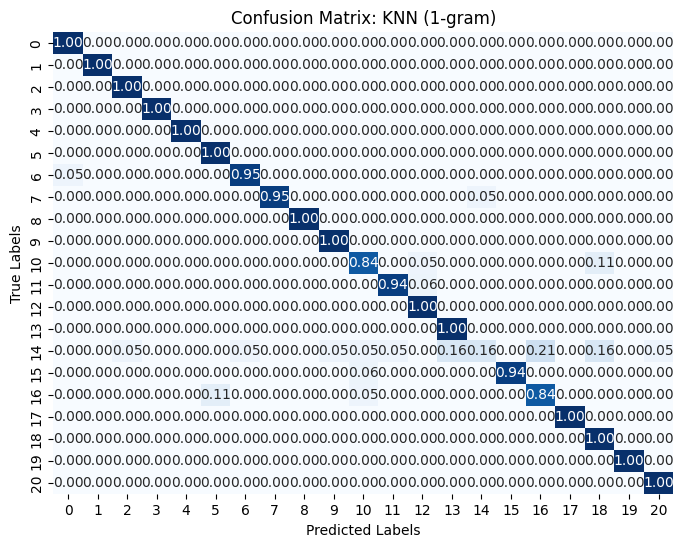


=== SVM Model (1-gram) ===

SVM (1-gram) Performance:
Accuracy: 0.9642
Recall: 0.9642
Precision: 0.9649
F1-Score: 0.9642

Normalized Confusion Matrix:
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.00 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.0

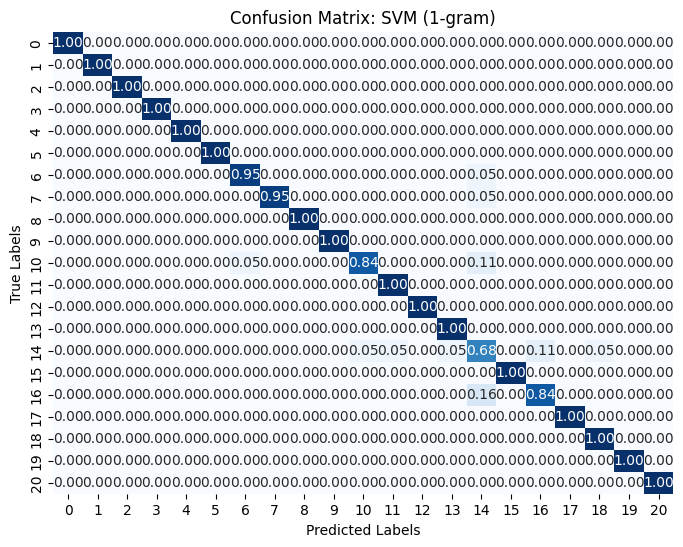


=== Decision Tree Model (1-gram) ===

Decision Tree (1-gram) Performance:
Accuracy: 0.8747
Recall: 0.8747
Precision: 0.8663
F1-Score: 0.8655

Normalized Confusion Matrix:
0.94 0.00 0.00 0.06 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.06 0.94 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.06 0.00 0.00 0.94 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.06 0.00 0.00 0.00 0.06 0.89 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.05 0.00 0.00 0.00 0.00 0.05 0.89 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.84 0.00 0.00 0.00 0.00 0.00 0.11 0.00 0.00 0.05 0.00 0.0

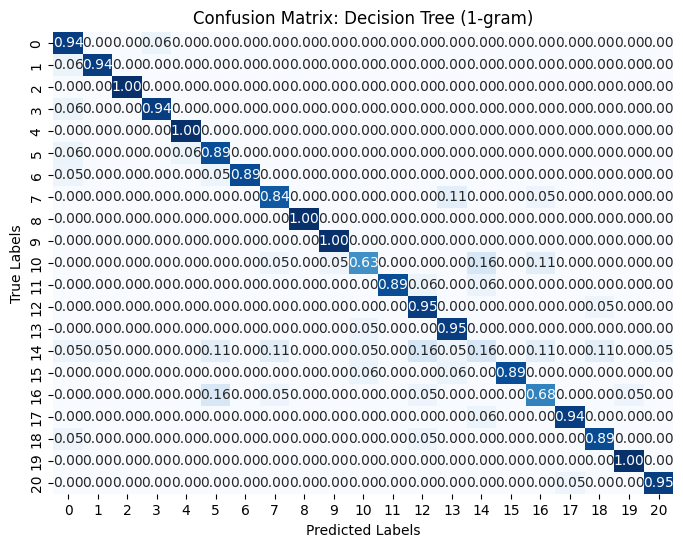


=== KNN Model (2-gram) ===

KNN (2-gram) Performance:
Accuracy: 0.9284
Recall: 0.9284
Precision: 0.8913
F1-Score: 0.9073

Normalized Confusion Matrix:
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.05 0.95 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.00 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.0

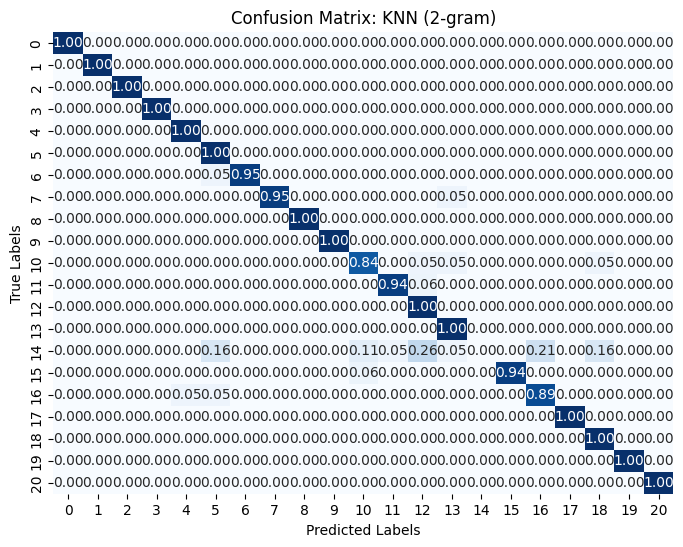


=== SVM Model (2-gram) ===

SVM (2-gram) Performance:
Accuracy: 0.9821
Recall: 0.9821
Precision: 0.9815
F1-Score: 0.9814

Normalized Confusion Matrix:
1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.0

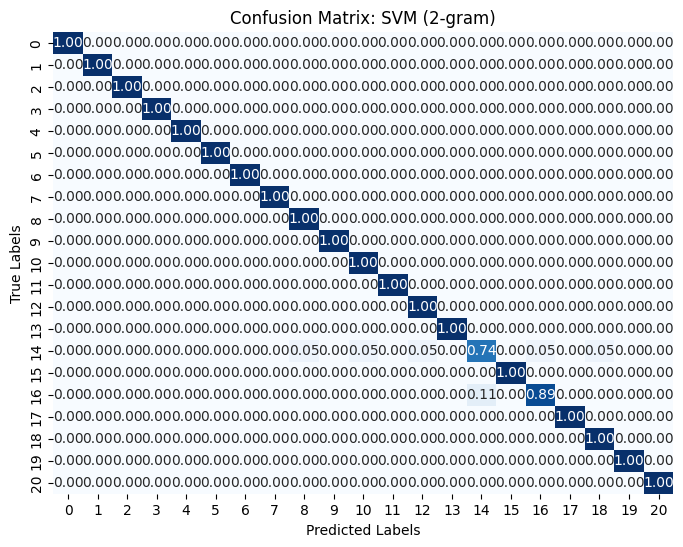


=== Decision Tree Model (2-gram) ===

Decision Tree (2-gram) Performance:
Accuracy: 0.8670
Recall: 0.8670
Precision: 0.8631
F1-Score: 0.8610

Normalized Confusion Matrix:
0.94 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.06 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.94 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.06 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.89 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.11 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.89 0.00 0.00 0.00 0.00 0.00 0.11 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 1.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.94 0.00 0.00 0.00 0.00 0.00 0.06 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.95 0.00 0.00 0.00 0.05 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.00
0.00 0.00 0.00 0.00 0.00 0.00 0.00 0.84 0.00 0.00 0.00 0.00 0.05 0.00 0.11 0.00 0.00 0.00 0.0

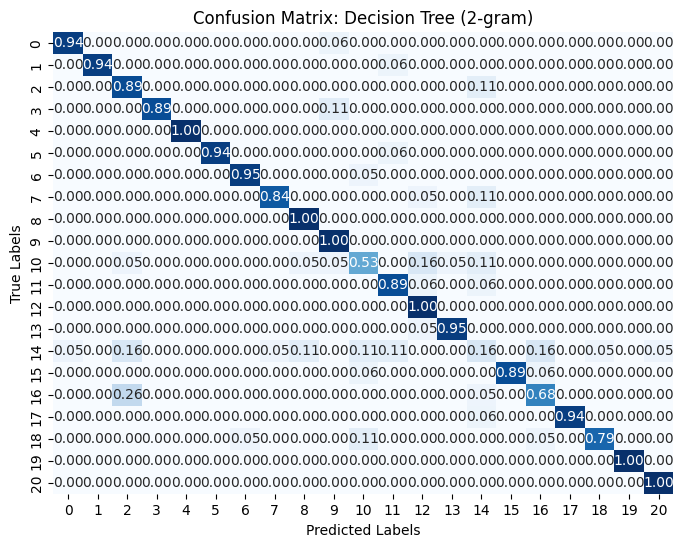

In [27]:
# Hyperparameters and Model Training 
knn_params = {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']}
svm_params = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}
dt_params = {'max_depth': [10, 20], 'min_samples_split': [2, 5]}

print("\n=== KNN Model (1-gram) ===")
evaluate_model("KNN (1-gram)", KNeighborsClassifier(), knn_params, X_train_1gram, y_train_1gram, X_test_1gram, y_test_1gram)

print("\n=== SVM Model (1-gram) ===")
evaluate_model("SVM (1-gram)", SVC(), svm_params, X_train_1gram, y_train_1gram, X_test_1gram, y_test_1gram)

print("\n=== Decision Tree Model (1-gram) ===")
evaluate_model("Decision Tree (1-gram)", DecisionTreeClassifier(), dt_params, X_train_1gram, y_train_1gram, X_test_1gram, y_test_1gram)

print("\n=== KNN Model (2-gram) ===")
evaluate_model("KNN (2-gram)", KNeighborsClassifier(), knn_params, X_train_2gram, y_train_2gram, X_test_2gram, y_test_2gram)

print("\n=== SVM Model (2-gram) ===")
evaluate_model("SVM (2-gram)", SVC(), svm_params, X_train_2gram, y_train_2gram, X_test_2gram, y_test_2gram)

print("\n=== Decision Tree Model (2-gram) ===")
evaluate_model("Decision Tree (2-gram)", DecisionTreeClassifier(), dt_params, X_train_2gram, y_train_2gram, X_test_2gram, y_test_2gram)
